# State estimation with unknown $\mathbf{A}$
State space model
\begin{align*}
    &\mathbf{x}_n = \mathbf{A}\mathbf{x}_{n-1} + \mathbf{n} \quad \mathbf{n} \sim \mathcal{N}(\mathbf{0}, \mathbf{I}\gamma_x^{-1}) \\
    &y_n = \mathbf{c}^\text{T}\mathbf{x}_n + v \quad v \sim \mathcal{N}(0, \gamma_y^{-1})
\end{align*}

or

\begin{align*}
     &p(\mathbf{x}_n\,|\,\mathbf{x}_{n-1},\mathbf{a},\gamma) = \mathcal{N}\left(\mathbf{x}_n \;\middle|\; \mathbf{A}\mathbf{x}_{n-1},  \gamma_y^{-1} \right)\\
    &p(y_n\,|\,\mathbf{x}_{n}) = \mathcal{N}\left(y_n \;\middle|\;\mathbf{c}^\text{T}\mathbf{x}_n, \epsilon \right)
\end{align*}

where
\begin{align*}
    &\mathbf{x}_n = (x_n, x_{n-1}, \dots, x_{n-p+1})^\text{T} \quad \mathbf{x}_{n-1} = (x_{n-1}, x_{n-2}, \dots, x_{n-p})^\text{T} 
    \\ \\
    &\mathbf{A} = 
    \begin{bmatrix}
        a_1 & a_2 & a_3 & \dots & a_p \\
        1 & 0 & 0 & \dots & 0 \\ 
        0 & 1 & 0 & \dots & 0 \\   
        \vdots & \vdots & \vdots & \ddots & \vdots \\
        0 & 0 & 0 & \dots & 0
    \end{bmatrix}
    =
    \begin{bmatrix}
         \mathbf{a}^\text{T} \\
         \mathbf{I}_{p-1} \quad \mathbf{0}
    \end{bmatrix}
    \\ \\
    &\mathbf{I} = \mathbf{I}_p = 
    \begin{bmatrix}
        1 & 0 & 0 & \dots & 0 \\ 
        0 & 1 & 0 & \dots & 0 \\   
        \vdots & \vdots & \vdots & \ddots & \vdots \\
        0 & 0 & 0 & \dots & 1
    \end{bmatrix} \\
\end{align*}

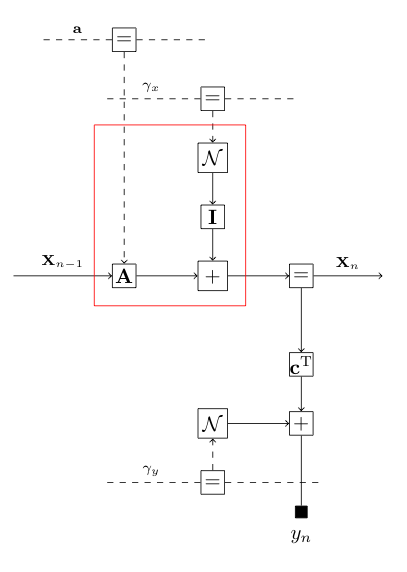

In [234]:
using Images
img = load("../ffgs/HAR-online.png")

The central quantity of our interest is a joint estimation of the AR coefficients $\mathbf{a}$ and states $\mathbf{x}_n$, while setting noises' precision $\gamma_x=1$, $\gamma_y=1/2$.

In [63]:
using ProgressMeter
using Revise
using ForneyLab
include( "../AR-node/autoregression.jl")
include("../AR-node/rules_prototypes.jl")
include("../AR-node/vmp_rules.jl")
# helpers for evaluation of the model
include("../helpers/functions.jl")
# module to generate data for AR
include("../data/ARdata.jl")
import Main.ARdata: use_data, generate_data
import LinearAlgebra.I, LinearAlgebra.Symmetric
import ForneyLab: unsafeCov, unsafeMean, unsafePrecision

In [76]:
ARorder = 5 # order of AR model
diagAR(dim) = Matrix{Float64}(I, dim, dim)
x = []
# AR data
a_w = 1.0; b_w = 1.0
process_noise = b_w/a_w
coefs, x = generate_data(1000, ARorder, 1, noise_variance=process_noise)
# Observations
measurement_noise = 2.0
y = [xi[1] + sqrt(measurement_noise)*randn() for xi in x[ARorder:end]]

996-element Array{Float64,1}:
 -1.6367977907157076 
 -0.0820064213775531 
 -0.786767055678435  
 -2.9391389199034075 
  2.364229827554791  
  2.448203287567344  
  3.331251928388649  
  2.6556321403112277 
  1.672932112373615  
 -0.7528976513537503 
 -2.5046717992923626 
 -0.10477342606226725
 -0.9199098073876928 
  ⋮                  
  6.460325156542119  
 -0.60613338355468   
 -4.718712191744517  
 -3.8497150205902417 
 -0.2808844221067506 
  1.0047808239099874 
  1.1003792707098923 
  2.166929373777747  
  0.793209131760673  
  1.3702199404028894 
 -2.082841956926583  
 -2.8220752347757587 

In [77]:
# Building the model
g = FactorGraph()

# declare priors as random variables
@RV m_x_t_prev
@RV w_x_t_prev
@RV m_a_t
@RV w_a_t
@RV m_y_t

@RV a ~ GaussianMeanPrecision(m_a_t, w_a_t)
@RV x_t_prev ~ GaussianMeanPrecision(m_x_t_prev, w_x_t_prev)
@RV w ~ Gamma(a_w, b_w)
@RV x_t = AR(a, x_t_prev, w)
c = zeros(ARorder); c[1] = 1.0
@RV y_t ~ GaussianMeanPrecision(m_y_t, measurement_noise^-1)
DotProduct(y_t, c, x_t)

# Placeholders for prior
placeholder(m_x_t_prev, :m_x_t_prev, dims=(ARorder,))
placeholder(w_x_t_prev, :w_x_t_prev, dims=(ARorder, ARorder))
placeholder(m_a_t, :m_a_t, dims=(ARorder,))
placeholder(w_a_t, :w_a_t, dims=(ARorder, ARorder))

# Placeholder for data
placeholder(m_y_t, :m_y_t)

ForneyLab.draw(g)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 5606728400698616351 -->
 
 5606728400698616351 
 
 placeholder_w_a_t 
 
<!-- 1047009489399404582 -->
 
 1047009489399404582 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 5606728400698616351--1047009489399404582 -->
 
 5606728400698616351--1047009489399404582 
 
 w_a_t 
 3 w 
 1 out 
 
<!-- 6611629870870971931 -->
 
 6611629870870971931 
 
 placeholder_m_y_t 
 
<!-- 1681861134129634760 -->
 
 1681861134129634760 
 
 𝒩 
 gaussianmeanprecision_3 
 
<!-- 6611629870870971931--1681861134129634760 -->
 
 6611629870870971931--1681861134129634760 
 
 m_y_t 
 2 m 
 1 out 
 
<!-- 3383450705731758558 -->
 
 3383450705731758558 
 
 clamp_4 
 
<!-- 14326432929644345617 -->
 
 14326432929644345617 
 
 clamp_3 
 
<!-- 7831602625210371514 -->
 
 7831602625210371514 
 
 clamp_2 
 
<!-- 1495591984421734596 -->
 
 1495591984421734596 
 
 Autoregression 
 autoregression_1 
 
<!-- 1495591984421734596--1047009489399404582 -->
 
 1495591984421734596--1047009489399404582 
 
 a 
 1 out 
 3 a 
 
<!-- 2808039179291782486 -->
 
 2808039179291782486 
 
 Gam 
 gamma_1 
 
<!-- 1495591984421734596--2808039179291782486 -->
 
 1495591984421734596--2808039179291782486 
 
 w 
 1 out 
 4 W 
 
<!-- 706215377029475257 -->
 
 706215377029475257 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 1495591984421734596--706215377029475257 -->
 
 1495591984421734596--706215377029475257 
 
 x_t_prev 
 1 out 
 2 x 
 
<!-- 2808039179291782486--7831602625210371514 -->
 
 2808039179291782486--7831602625210371514 
 
 clamp_2 
 1 out 
 3 b 
 
<!-- 9623140395532151350 -->
 
 9623140395532151350 
 
 clamp_1 
 
<!-- 2808039179291782486--9623140395532151350 -->
 
 2808039179291782486--9623140395532151350 
 
 clamp_1 
 1 out 
 2 a 
 
<!-- 16282930474655375390 -->
 
 16282930474655375390 
 
 placeholder_m_x_t_prev 
 
<!-- 16282930474655375390--706215377029475257 -->
 
 16282930474655375390--706215377029475257 
 
 m_x_t_prev 
 2 m 
 1 out 
 
<!-- 225195362693070950 -->
 
 225195362693070950 
 
 placeholder_m_a_t 
 
<!-- 225195362693070950--1047009489399404582 -->
 
 225195362693070950--1047009489399404582 
 
 m_a_t 
 2 m 
 1 out 
 
<!-- 1681861134129634760--14326432929644345617 -->
 
 1681861134129634760--14326432929644345617 
 
 clamp_3 
 1 out 
 3 w 
 
<!-- 2203558764461334606 -->
 
 2203558764461334606 
 
 placeholder_w_x_t_prev 
 
<!-- 2203558764461334606--706215377029475257 -->
 
 2203558764461334606--706215377029475257 
 
 w_x_t_prev 
 3 w 
 1 out 
 
<!-- 5568939401483139161 -->
 
 5568939401483139161 
 
 dot 
 dotproduct_1 
 
<!-- 5568939401483139161--3383450705731758558 -->
 
 5568939401483139161--3383450705731758558 
 
 clamp_4 
 1 out 
 2 in1 
 
<!-- 5568939401483139161--1495591984421734596 -->
 
 5568939401483139161--1495591984421734596 
 
 x_t 
 1 out 
 3 in2 
 
<!-- 5568939401483139161--1681861134129634760 -->
 
 5568939401483139161--1681861134129634760 
 
 y_t 
 1 out 
 1 out

In [78]:
# Specify recognition factorization
q = RecognitionFactorization(a, x_t, ids=[:A :X_t])

# Generate the variational update algorithms for each recognition factor
algo = variationalAlgorithm(q)

# Load algorithms
eval(Meta.parse(algo))

stepX_t! (generic function with 3 methods)

In [89]:
# Define values for prior statistics
m_a_0 = ones(ARorder)
w_a_0 = (0.0001*diagAR(ARorder))
m_x_prev_0 = zeros(ARorder)
w_x_prev_0 = (0.000001*diagAR(ARorder))

# Storage
m_x_prev = Vector{Vector{Float64}}(undef, length(y))
w_x_prev = Vector{Array{Float64, 2}}(undef, length(y))
m_a = Vector{Vector{Float64}}(undef, length(y))
w_a = Vector{Array{Float64, 2}}(undef, length(y))

# Inits
m_x_t_prev_min = m_x_prev_0
w_x_t_prev_min = w_x_prev_0
m_a_t_min = m_a_0
w_a_t_min = w_a_0;

In [96]:
marginals = Dict()
# VMP iterations
n_its = 10

# Storage for estimations
# FIXME: redundant
means = []
precisions = []
real = [x[1] for x in x[ARorder:end]]
# Storage for MSE of test set
WMSEs = []
p = Progress(length(y), 1, "Observed ")
for t in 1:length(y)
    update!(p, t)
    marginals[:a] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_a_t_min, w=w_a_t_min)
    marginals[:x_t_prev] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_x_t_prev_min, w=w_x_t_prev_min)
    marginals[:w] = ProbabilityDistribution(Univariate, Gamma, a=a_w, b=b_w)
    global m_x_t_prev_min, w_x_t_prev_min, m_a_t_min, w_a_t_min

    for i = 1:n_its
        data = Dict(:m_y_t => y[t],
                    :m_a_t => m_a_t_min,
                    :w_a_t => w_a_t_min,
                    :m_x_t_prev => m_x_t_prev_min,
                    :w_x_t_prev => w_x_t_prev_min)
        stepX_t!(data, marginals)
        stepA!(data, marginals)
        m_a[t] = unsafeMean(marginals[:a])
        w_a[t] = unsafePrecision(marginals[:a])
        m_x_prev[t] = unsafeMean(marginals[:x_t])
        w_x_prev[t] = unsafePrecision(marginals[:x_t])
        m_a_t_min = m_a[t]
        w_a_t_min = w_a[t]
        m_x_t_prev_min = m_x_prev[t]
        w_x_t_prev_min = w_x_prev[t]
    end
    push!(means, m_x_prev[t][1])
    push!(precisions, w_x_prev[t][1])
    push!(WMSEs, wmse(real[1:t], means, 1 ./ precisions))
end

Observed 100%|██████████████████████████████████████████| Time: 0:00:01


In [97]:
# MSE analysis
from = 1
estimated = [x[1] for x in m_x_prev[from:end]]
real = [x[1] for x in x[ARorder:end]]
noise = [y[1] for y in y[from:end]]

println("Δ(estimated, real)=", mse(estimated, real))
println("Δ(estimated, noise)=", mse(estimated, noise))
println("Δ(noise, actual)=", mse(noise, real))

Δ(estimated, real)=1.1484851210915297
Δ(estimated, noise)=1.729436487619815
Δ(noise, actual)=2.0267603556050764


In [98]:
using Plots

scale = 1.0 # scale for the variance
v_x = [v_x[1]^-1 for v_x in w_x_prev[1:end]] # variances of estimated state
toshow = 10 # number of points to plot at once

anim = @animate for i in 1:length(estimated)-toshow
    s = plot(xticks = i:div(toshow, 2):i+toshow);
    ylims!(minimum(noise) - .1, maximum(noise) + .1);
    scatter!(collect(i:i+toshow), noise[i:i+toshow], label="noisy observations", 
            markershape = :xcross, markeralpha = 0.6,
            markersize = 2)
    
    plot!(collect(i:i+toshow), [estimated[i:i+toshow], estimated[i:i+toshow]], fillrange=[estimated[i:i+toshow] -
          scale .* sqrt.(v_x[i:i+toshow]), estimated[i:i+toshow] + scale .* sqrt.(v_x[i:i+toshow])],
          linestyle=:dash, linewidth = 2,
          color=:black,
          fillalpha = 0.2,
          fillcolor = :black,
          label="inferred")
    
    plot!(collect(i:i+toshow), real[i:i+toshow], color = :magenta, linewidth = 1.0, label="real state")
end

Animation("/var/folders/jn/1xv7kskx42v_97gx1xd8y_g40000gq/T/tmp4IIUHA", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000977.png", "000978.png", "000979.png", "000980.png", "000981.png", "000982.png", "000983.png", "000984.png", "000985.png", "000986.png"])

In [99]:
gif(anim, "../gifs/KMPstate.gif", fps = 10)

┌ Info: Saved animation to 
│   fn = /Users/albertpod/Documents/Julia/VariationalBayes/gifs/KMPstate.gif
└ @ Plots /Users/albertpod/.julia/packages/Plots/gylTh/src/animation.jl:90


Plots.AnimatedGif("/Users/albertpod/Documents/Julia/VariationalBayes/gifs/KMPstate.gif")

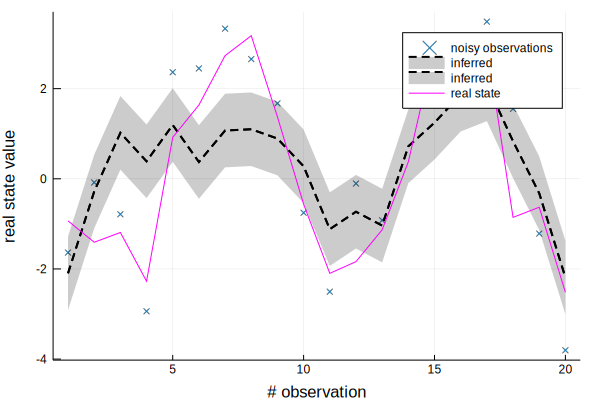

In [100]:
# Plotting
using Plots
upto = 20 # limit for building a graph
scale = 1.0 # scale for the variance
v_x = [v_x[1]^-1 for v_x in w_x_prev[1:end]] # variances of estimated state
scatter(noise[1:upto], label="noisy observations", 
        markershape = :xcross, markeralpha = 0.6,
        markersize = 2)
plot!([estimated[1:upto], estimated[1:upto]], fillrange=[estimated[1:upto] -
      scale .* sqrt.(v_x[1:upto]), estimated[1:upto] +
      scale .* sqrt.(v_x[1:upto])],
      linestyle=:dash,linewidth = 2,
      color=:black,
      fillalpha = 0.2,
      fillcolor = :black,
      label=["inferred", "inferred"])
plot!(real[1:upto], color = :magenta, linewidth = 1.0, label="real state")
plot!(xlabel="# observation", ylabel="real state value")

In [228]:
# Plotting MSE
anim2 = @animate for i in 1:length(WMSEs)
    s = plot()
    ylims!(minimum(WMSEs) - 1, maximum(WMSEs) + 1)
    xlims!(1, length(WMSEs))
    plot!(collect(1:i), WMSEs[1:i], xlabel="observation", ylabel="WMSE", label="")
end;

In [229]:
gif(anim2, "../gifs/MSE_evo_state.gif", fps = 100)

┌ Info: Saved animation to 
│   fn = /Users/albertpod/Documents/Julia/VariationalBayes/gifs/MSE_evo_state.gif
└ @ Plots /Users/albertpod/.julia/packages/Plots/gylTh/src/animation.jl:90


Plots.AnimatedGif("/Users/albertpod/Documents/Julia/VariationalBayes/gifs/MSE_evo_state.gif")

In [108]:
findmax(WMSEs)

(1.290938246530534e-23, 933)

In [350]:
y

996-element Array{Float64,1}:
  0.35823248640158434
 -0.39565859140044635
 -0.9289429703508629 
 -1.4916720546248008 
  1.428041677584451  
 -2.672832522449052  
  0.8574935496086413 
  3.8731962391320702 
 -2.7567416514374883 
 -0.18315853957034767
  2.619049915852508  
  0.13383793644458075
 -1.8258556159418042 
  ⋮                  
 -0.741102701343552  
  1.7815882411052404 
 -1.1196927087757547 
  0.8852806422370854 
  1.3782246003891037 
 -4.8682880007616225 
  3.7604564663778284 
  2.207132368990709  
 -2.2259830314252964 
  2.5783399907865228 
  4.701942442198192  
 -4.802716643850074  

10

In [226]:
coefs

10-element Array{Float64,1}:
  0.1107138598270957 
  0.0890881026598277 
  0.14708760366291296
 -0.5650931265602253 
  0.3474355486307712 
  0.05241729640398174
 -0.383240176391437  
 -0.1580886399193822 
  0.08489094471726633
  0.15328724722745435

In [227]:
mean(marginals[:a])

10-element Array{Float64,1}:
 -0.09402526744221756  
  0.0036007482363666736
  0.09228888637793603  
 -0.17031709650496382  
  0.09312551586522952  
  0.02536549931816468  
 -0.13508175121271054  
  0.09138289311424518  
 -0.07088531840121157  
 -0.012246498220954596 